In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

In [2]:
with open(pickle_dir / 'population_patterns.p', 'rb') as f: 
    population_patterns = pickle.load(f)

In [3]:
def plot_overlaps(all_overlaps, title):
    plt.figure()
    plt.hist(all_overlaps, bins=20, alpha=0.4, weights=np.ones(len(all_overlaps)) / len(all_overlaps))
    plt.title(title, fontsize=14)
    plt.ylabel("Proportion of Visits", fontsize=12)
    plt.xlabel("Population Overlap", fontsize=12)
    plt.xlim((0, 1))
    plt.ylim((0, 0.6))
    plt.show()
    print(len(all_overlaps))

## Activity Overlap between Cache/Retrieval with highest pair removed

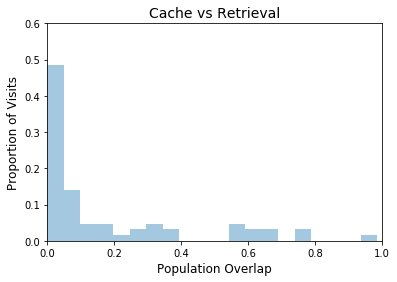

64


In [23]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    visit_patterns = population_patterns[fil_string]['visit_patterns']

    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        cache_pattern_mat = visit_patterns[c_visit]
        for j, r_visit in enumerate(r_visits):
            if r_visit <= c_visit: continue
            overlaps = []
            r_site = exp_data.cr_sites[exp_data.cr_was_retrieval][j]
            if r_site != c_site: continue
            retriev_pattern_mat = visit_patterns[r_visit]
            for retriev_pattern in retriev_pattern_mat.T:
                for c in cache_pattern_mat.T:
                    x = c.copy()
                    y = retriev_pattern.copy()
                    high_pair = np.argmax(x*y).squeeze()
                    x[high_pair] = 0
                    y[high_pair] = 0
                    cache_retriev_overlap = popln_overlap(
                        x[:,None], y
                        )
                    if np.isnan(cache_retriev_overlap): continue
                    overlaps.append(cache_retriev_overlap)
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
            break
        
plot_overlaps(all_overlaps, "Cache vs Retrieval")

# Activity Overlap Between Caching and Retrieval of Same Cache

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: All-NaN axis encountered


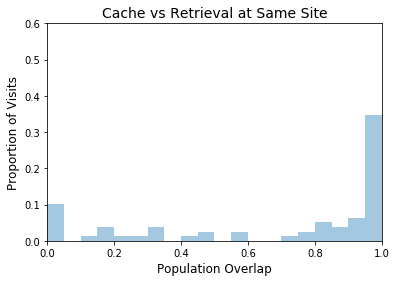

78


In [61]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    visit_patterns = population_patterns[fil_string]['visit_patterns']

    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        cache_pattern_mat = visit_patterns[c_visit]
        for j, r_visit in enumerate(r_visits):
            if r_visit <= c_visit: continue
            overlaps = []
            r_site = exp_data.cr_sites[exp_data.cr_was_retrieval][j]
            if r_site != c_site: continue
            retriev_pattern_mat = visit_patterns[r_visit]
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                overlaps.append(np.nanmax(cache_retriev_overlap))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
            break
        
plot_overlaps(all_overlaps, "Cache vs Retrieval at Same Site")

### View patterns and define new episode cells by cells that support overlap

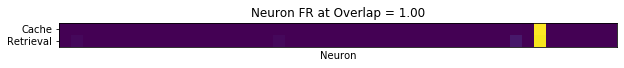

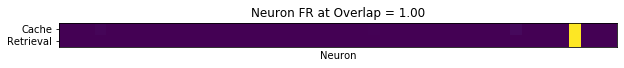

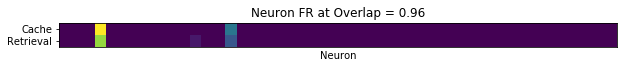

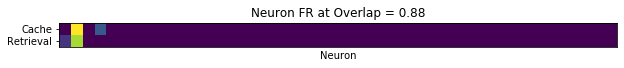

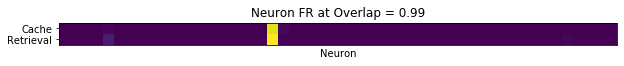

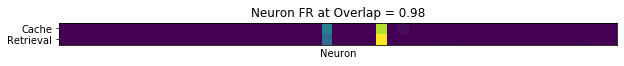

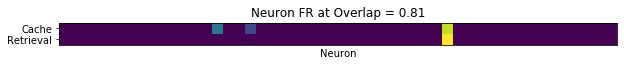

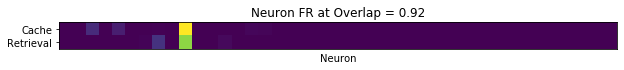

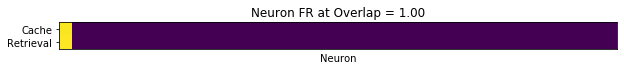

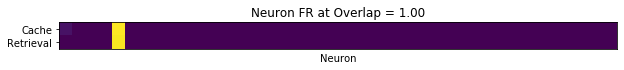

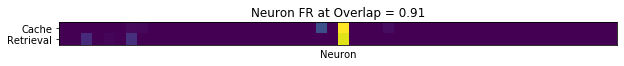

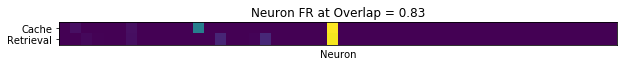

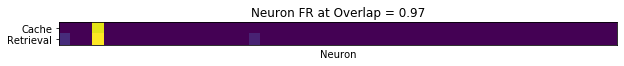

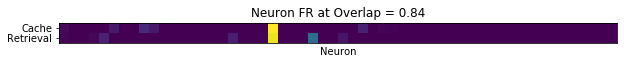

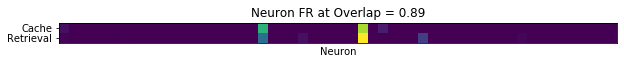

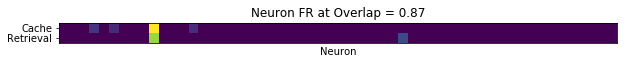

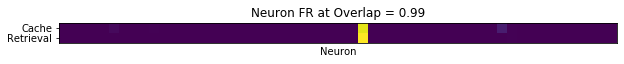

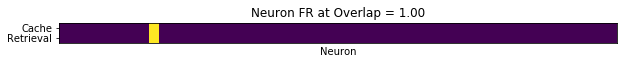

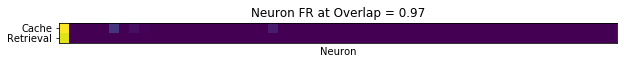

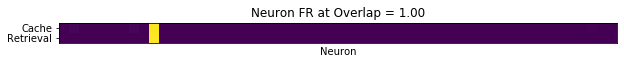

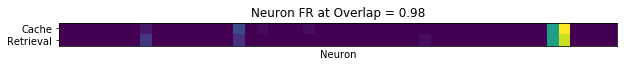

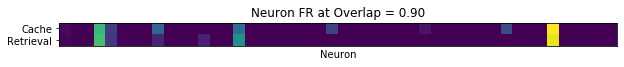

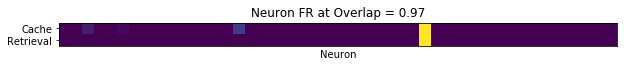

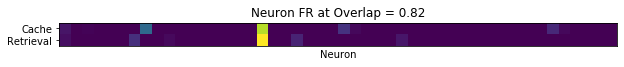

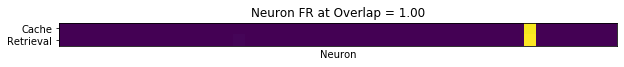

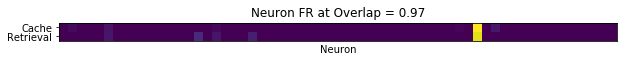

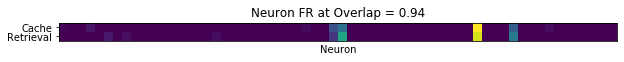

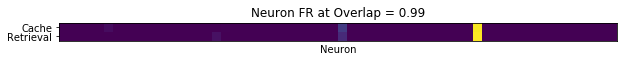

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in greater
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: All-NaN axis encountered


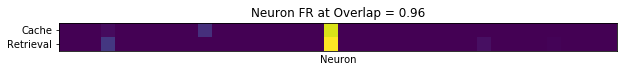

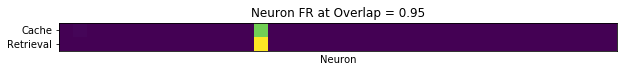

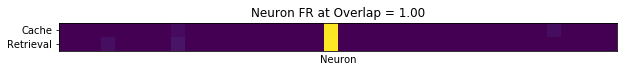

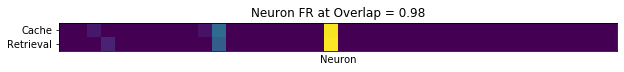

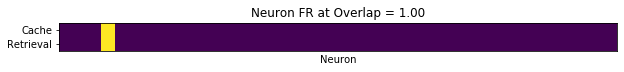

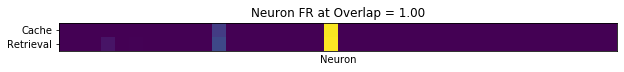

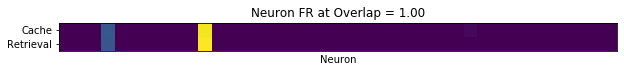

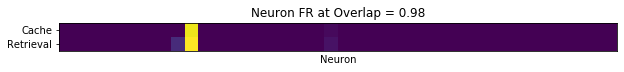

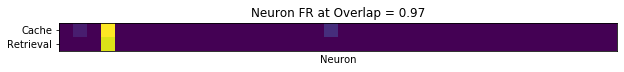

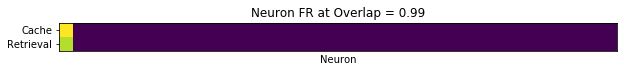

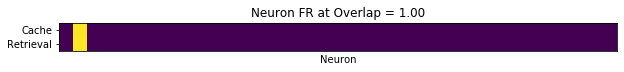

In [65]:
data = {}
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    data[fil_string] = {}
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    cache_idx_mat = np.zeros((c_visits.size, exp_data.num_neurs))
    significance = np.zeros(exp_data.num_neurs)

    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        cache_pattern_mat = visit_patterns[c_visit]
        for j, r_visit in enumerate(r_visits):
            if r_visit <= c_visit: continue
            overlaps = []
            r_site = exp_data.cr_sites[exp_data.cr_was_retrieval][j]
            if r_site != c_site: continue
            retriev_pattern_mat = visit_patterns[r_visit]
            max_patterns = []
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                overlaps.append(np.nanmax(cache_retriev_overlap))
                max_patterns.append([
                    cache_pattern_mat[:,np.argmax(cache_retriev_overlap)], retriev_pattern
                    ])
            if len(overlaps) > 0:
                max_patterns = np.array(max_patterns[np.argmax(overlaps)])
                support_neurs = np.argwhere(max_patterns[0]*max_patterns[1] > 0).squeeze()
#                 true_pattern = np.zeros(exp_data.num_neurs)
#                 true_pattern[support_neurs] = np.mean(max_patterns[:, support_neurs], axis=0)
                true_pattern = np.mean(max_patterns, axis=0)
                cache_idx_mat[i, :] = true_pattern
                significance[support_neurs] = 1
                max_overlap = np.nanmax(overlaps)
                if max_overlap > 0.8:
                    plt.figure(figsize=(10,10))
                    plt.imshow(max_patterns)
                    plt.xticks([])
                    plt.xlabel("Neuron")
                    plt.yticks([0,1], ['Cache', 'Retrieval'])
                    plt.title(f"Neuron FR at Overlap = {max_overlap:.2f}")
                    plt.show()
            break
    data[fil_string]['cr_idx_mat'] = cache_idx_mat
    data[fil_string]['significance'] = significance
with open(pickle_dir / 'episode_cells_overlap.p', 'wb') as f: 
    pickle.dump(data, f)

# Activity Overlap Between Caching and Retrieval of Different Cache

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: All-NaN axis encountered


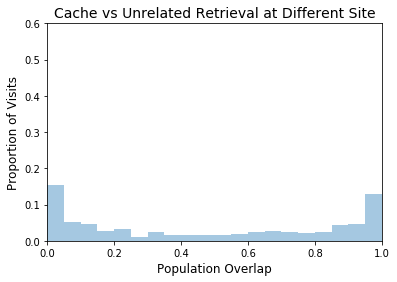

983


In [28]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        cache_pattern_mat = visit_patterns[c_visit]
        mean_overlaps = []
        for j, r_visit in enumerate(r_visits):
            r_site = exp_data.cr_sites[exp_data.cr_was_retrieval][j]
            if r_site == c_site: continue
            retriev_pattern_mat = visit_patterns[r_visit]
            overlaps = []
            for retriev_pattern in retriev_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, retriev_pattern)
                    ))
            if len(overlaps) > 0:
                mean_overlaps.append(np.nanmax(overlaps))
        all_overlaps.extend(mean_overlaps)
        #all_overlaps.append(np.nanmean(mean_overlaps))
        
plot_overlaps(all_overlaps, "Cache vs Unrelated Retrieval at Different Site")

# Activity Overlap Between Caching and Retrieval at Same Site

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        cache_pattern_mat = visit_patterns[c_visit]
        retrieved = False
        mean_overlaps = []
        for j, r_visit in enumerate(r_visits):
            overlaps = []
            r_site = exp_data.cr_sites[exp_data.cr_was_retrieval][j]
            if r_site != c_site: continue
            if (r_visit > c_visit) and not retrieved:
                retrieved = True
                continue
            retriev_pattern_mat = visit_patterns[r_visit]
            for retriev_pattern in retriev_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, retriev_pattern)
                    ))
            if len(overlaps) > 0:
                mean_overlaps.append(np.nanmax(overlaps))
        #all_overlaps.extend(mean_overlaps)
        all_overlaps.append(np.nanmean(mean_overlaps))
        
plot_overlaps(all_overlaps, "Cache vs Unrelated Retrieval at Same Site")

# Activity Overlap Between Same Site Caching

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        cache_pattern_mat = visit_patterns[c_visit]
        retrieved = False
        mean_overlaps = []
        for j, c2_visit in enumerate(c_visits):
            if j <= i: continue
            c2_site = exp_data.cr_sites[exp_data.cr_was_cache][j]
            if c_site != c2_site: continue
            cache2_pattern_mat = visit_patterns[c2_visit]
            overlaps = []
            for cache2_pattern in cache2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, cache2_pattern)
                    ))
            if len(overlaps) > 0:
                mean_overlaps.append(np.nanmax(overlaps))
        all_overlaps.append(np.nanmean(mean_overlaps))
        
plot_overlaps(all_overlaps, "Cache vs Unrelated Cache at Same Site")

# Activity Overlap Between Different Site Caching

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        cache_pattern_mat = visit_patterns[c_visit]
        retrieved = False
        mean_overlaps = []
        for j, c2_visit in enumerate(c_visits):
            if j <= i: continue
            c2_site = exp_data.cr_sites[exp_data.cr_was_cache][j]
            if c_site == c2_site: continue
            cache2_pattern_mat = visit_patterns[c2_visit]
            overlaps = []
            for cache2_pattern in cache2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, cache2_pattern)
                    ))
            if len(overlaps) > 0:
                mean_overlaps.append(np.nanmax(overlaps))
        all_overlaps.append(np.nanmean(mean_overlaps))
        
plot_overlaps(all_overlaps, "Cache vs Unrelated Cache at Different Site")

# Activity Overlap Between Same Site Retrieval

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, r_visit in enumerate(r_visits):
        r_site = exp_data.cr_sites[exp_data.cr_was_retrieval][i]
        retriev_pattern_mat = visit_patterns[r_visit]
        for j, r2_visit in enumerate(r_visits):
            if j <= i: continue
            r2_site = exp_data.cr_sites[exp_data.cr_was_retrieval][j]
            if r_site != r2_site: continue
            retriev2_pattern_mat = visit_patterns[r2_visit]
            overlaps = []
            for retriev2_pattern in retriev2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(retriev_pattern_mat, retriev2_pattern)
                    ))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Retrieval vs Unrelated Retrieval at Same Site")

# Activity Overlap Between Different Site Retrieval

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, r_visit in enumerate(r_visits):
        r_site = exp_data.cr_sites[exp_data.cr_was_retrieval][i]
        retriev_pattern_mat = visit_patterns[r_visit]
        for j, r2_visit in enumerate(r_visits):
            if j <= i: continue
            r2_site = exp_data.cr_sites[exp_data.cr_was_retrieval][j]
            if r_site == r2_site: continue
            retriev2_pattern_mat = visit_patterns[r2_visit]
            overlaps = []
            for retriev2_pattern in retriev2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(retriev_pattern_mat, retriev2_pattern)
                    ))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Retrieval vs Unrelated Retrieval at Different Site")

# Activity Overlap Between Caching and Arbitrary Visit

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: All-NaN axis encountered


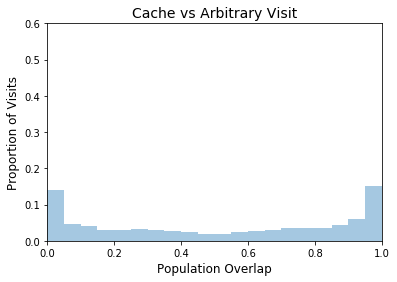

5119


In [36]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, c_visit in enumerate(c_visits):
        c_site = exp_data.cr_sites[exp_data.cr_was_cache][i]
        cache_pattern_mat = visit_patterns[c_visit]
        for j, noncr_visit in enumerate(noncr_visits):
            overlaps = []
            noncr_site = exp_data.visit_wedges[noncr_visit]
            if noncr_site != c_site: continue
            navig_pattern_mat = visit_patterns[noncr_visit]
            for navig_pattern in navig_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(cache_pattern_mat, navig_pattern)
                    ))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Cache vs Arbitrary Visit")

# Activity Overlap Between Retrieval and Arbitrary Visit

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, r_visit in enumerate(r_visits):
        r_site = exp_data.cr_sites[exp_data.cr_was_retrieval][i]
        retriev_pattern_mat = visit_patterns[r_visit]
        for j, noncr_visit in enumerate(noncr_visits):
            noncr_site = exp_data.visit_wedges[noncr_visit]
            if noncr_site != r_site: continue
            navig_pattern_mat = visit_patterns[noncr_visit]
            overlaps = []
            for navig_pattern in navig_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(retriev_pattern_mat, navig_pattern)
                    ))
            if len(overlaps) > 0:
                all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Retrieval vs Arbitrary Visit")

# Activity Overlap Between Arbitrary Visit and Arbitrary Visit

In [ ]:
all_overlaps = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, noncr_visit in enumerate(noncr_visits):
        noncr_site = exp_data.visit_wedges[noncr_visit]
        navig_pattern_mat = visit_patterns[noncr_visit]
        overlaps = []
        for j, noncr2_visit in enumerate(noncr_visits):
            if j <= i: continue
            noncr2_site = exp_data.visit_wedges[noncr2_visit]
            if noncr2_site == noncr_site: continue
            navig2_pattern_mat = visit_patterns[noncr2_visit]
            for navig2_pattern in navig2_pattern_mat.T:
                overlaps.append(np.nanmax(
                    popln_overlap(navig_pattern_mat, navig2_pattern)
                    ))
        if len(overlaps) > 0:
            all_overlaps.append(np.nanmax(overlaps))
        
plot_overlaps(all_overlaps, "Arbitrary Visit vs Arbitrary Visit")

### View patterns 

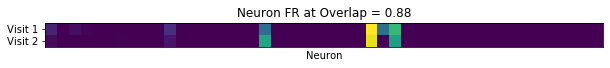

[0.88042885]


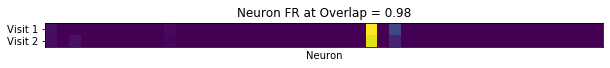

[0.98114468]


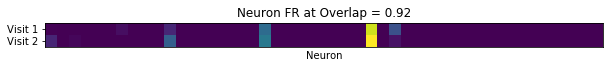

[0.91980695]


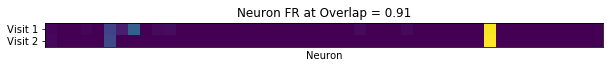

[0.90847863]


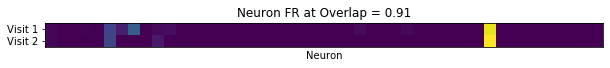

[0.90862138]


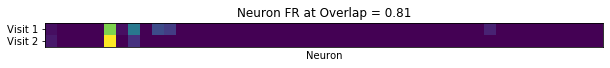

[0.81024152]


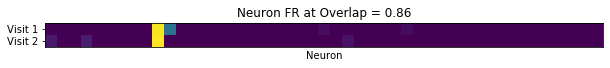

[0.86272008]


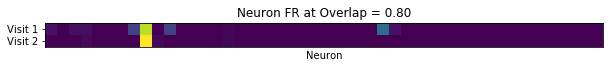

[0.80134032]


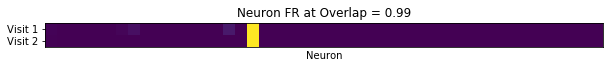

[0.99372307]


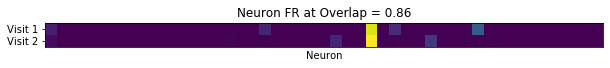

[0.86372553]


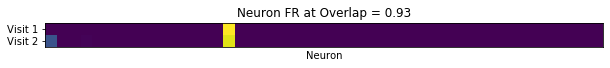

[0.93370837]


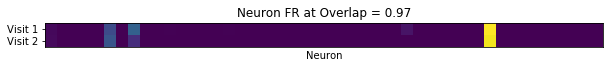

[0.9673202]


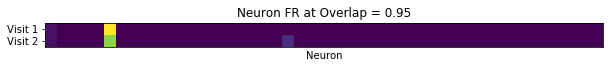

[0.94570836]


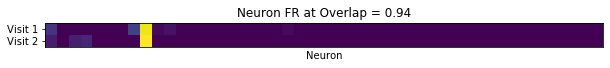

[0.93591292]


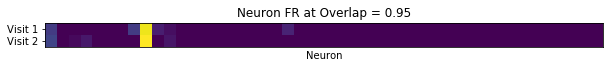

[0.9492486]


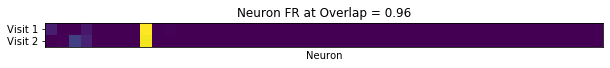

[0.95768032]


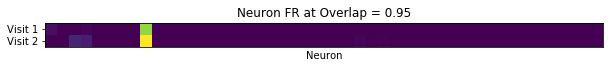

[0.95027976]


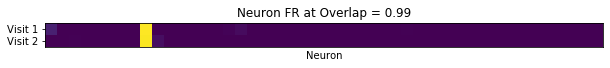

[0.98984474]


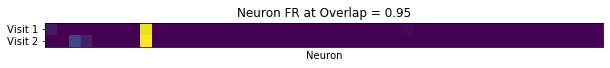

[0.94512613]


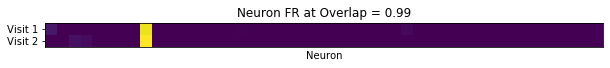

[0.99126527]


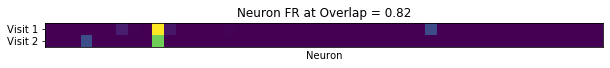

[0.82320357]


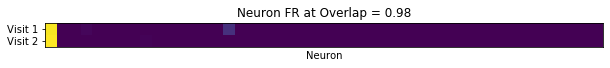

[0.98038193]


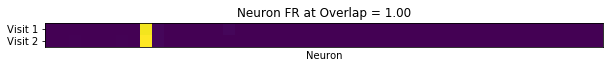

[0.99937354]


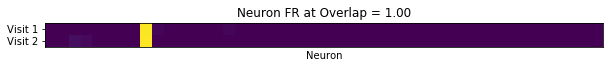

[0.99723535]


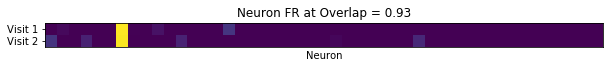

[0.92611778]


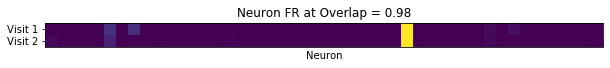

[0.97678582]


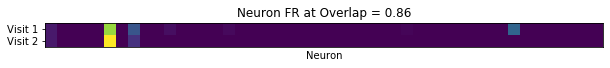

[0.85893399]


KeyboardInterrupt: 

In [53]:
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    c_visits = population_patterns[fil_string]['c_visits']
    r_visits = population_patterns[fil_string]['r_visits']
    noncr_visits = population_patterns[fil_string]['noncr_visits']
    fr = population_patterns[fil_string]['fr']
    visit_patterns = population_patterns[fil_string]['visit_patterns']
    for i, noncr_visit in enumerate(noncr_visits):
        noncr_site = exp_data.visit_wedges[noncr_visit]
        navig_pattern_mat = visit_patterns[noncr_visit]
        for j, noncr2_visit in enumerate(noncr_visits):
            if j <= i: continue
            noncr2_site = exp_data.visit_wedges[noncr2_visit]
            if noncr2_site != noncr_site: continue
            navig2_pattern_mat = visit_patterns[noncr2_visit]
            overlaps = []
            max_patterns = []
            for navig2_pattern in navig2_pattern_mat.T:
                for navig_pattern in navig_pattern_mat.T:
                    _overlap = popln_overlap(navig_pattern[:,None], navig2_pattern)[0]
                    if np.isnan(_overlap): continue
                    overlaps.append(_overlap)
                    max_patterns.append([navig_pattern, navig2_pattern])
            if len(overlaps) > 0:
                max_overlap = np.nanmax(overlaps)
                max_overlap_idx = np.argmax(overlaps).squeeze()
                all_overlaps.append(max_overlap)
                if max_overlap > 0.8 and np.random.uniform() > 0.98:
                    max_patterns = np.array(max_patterns[max_overlap_idx])
                    plt.figure(figsize=(10,10))
                    plt.imshow(max_patterns)
                    plt.xticks([])
                    plt.xlabel("Neuron")
                    plt.yticks([0,1], ['Visit 1', 'Visit 2'])
                    plt.title(f"Neuron FR at Overlap = {max_overlap:.2f}")
                    plt.show()
                    print(popln_overlap(max_patterns[0][:,None], max_patterns[1]))
